# Where to invest in Vienna Real Estate Market

## Table of Contents

1. <a href="#item1">Description of the problem and discussion of the backbround</a>
2. <a href="#item2">Description of the data and how it will be used to solve the problem</a>  
3. <a href="#item3">Methodology and results</a>  
4. <a href="#item4">Discussion</a>
5. <a href="#item5">Conclusion</a>

## 1. Description of the problem and discussion of the backbround
Vienna has been announced the most liveable city in the world by the Mercer Study ten times in a row, the prices for real estate are still relatively low (despite a strong increase in prices in the last years) compared to other big cities in Europe like Hamburg or Munich, the city’s population is growing, the job market situation is very good and the interest rates for loans are extremely low in Europe.

But where in Vienna could you invest? As someone who might want to buy an apartment in Vienna it might be interesting to get an idea about the different boroughs in Vienna, the average prices of apartments there and the venues offered (depending on how much someone is willing to pay per m² and what opportunities he or she wants to have near the apartment he might get an idea which borough could be interesting).

## 2. Description of the data and how it will be used to solve the problem
- The boroughs of Vienna with the postal codes are drawn the following website: https://www.vienna.at/features/bezirke-wien
- The latitude and longitude of the boroughs are drawn from the geocoder package (using the provider ArcGIS).
- The latitude and longitude of Vienna is drawn from the Nominatim geocoder.
- Json File for choropleth map from https://github.com/codeforamerica/click_that_hood/blob/master/public/data/vienna.geojson?short_path=91a4361
- As there seems to be no actual official statistics publicly available (e.g. from Statistics Austria or Oesterreichische Nationalbank) on the average prices of apartments in Vienna per borough I will use the price data of a site where a lot of apartments are advertised (https://derstandard.at/Immopreise/Wien/Wohnung/Eigentum). The average price will be used as one variable in the analysis.
- Foursquare will be used to get an idea of the venues offered nearby (in the different boroughs).

## 3. Methodology and results

### 3.1 Importing the libraries

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
!pip install geocoder
import geocoder

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
print('Libraries imported.')
! pip install -U scikit-learn
from sklearn.preprocessing import StandardScaler
! pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

    100% |████████████████████████████████| 102kB 17.9MB/s 
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    certifi-2019.3.9           |           py36_0         149 KB  conda-forge
    conda-4.6.11               |           py36_0         897 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    geopy-1.19.0               |             py_0          53 KB  conda-forge
    openssl-1.1.1b             |       h14c3975_1         4.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.2 MB

The following NEW packages will be INSTALLED:

  geographiclib 

### 3.2 Download the postalcodes and boroughs of Vienna from Vienna.at

In [92]:
url = "https://www.vienna.at/features/bezirke-wien"
res = requests.get(url)
soup = BeautifulSoup(res.text,'lxml')

bor = soup.select(".bezirke-middle")
plc = soup.select(".bezirke-right")

bor_titles = [title.text for title in bor]
plc_titles = [title.text for title in plc]

bor_titles = bor_titles[0:23]
plc_titles = plc_titles[0:23]

### 3.3 Creating a Dataframe

In [93]:
column_names = ['Postalcode','Borough']
vienna = pd.DataFrame(columns = column_names)

vienna['Postalcode'] = plc_titles
vienna['Borough'] = bor_titles

vienna.head()

,Postalcode,Borough
0,1010 Wien,Innere Stadt
1,1020 Wien,Leopoldstadt
2,1030 Wien,Landstraße
3,1040 Wien,Wieden
4,1050 Wien,Margareten


### 3.4 Cleaning the dataframe

Removing the " Wien"-part from postalcode

In [94]:
vienna['Postalcode'] = vienna['Postalcode'].str.slice(stop=4)

vienna.head()

,Postalcode,Borough
0,1010,Innere Stadt
1,1020,Leopoldstadt
2,1030,Landstraße
3,1040,Wieden
4,1050,Margareten


### 3.5 Adding the latitude and longitude coordinates of each borough

Function for getting the coordinates (using the geocoder package, but arcgis instead of google)

In [95]:
def get_latlng(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Vienna'.format(postal_code))
        lat_lng_coords = g.latlng
    return lat_lng_coords

Getting the coordinates via the function and adding the latitude and longitude to the dataframe

In [96]:
coords = [ get_latlng(postal_code) for postal_code in vienna['Postalcode'] .tolist() ]
coords = pd.DataFrame(coords)
vienna['Latitude'] = coords[0]
vienna['Longitude'] = coords[1]

Show the first few rows of the created dataframe

In [97]:
vienna.head()

,Postalcode,Borough,Latitude,Longitude
0,1010,Innere Stadt,48.209075,16.369614
1,1020,Leopoldstadt,48.199922,16.425665
2,1030,Landstraße,48.194205,16.395600
3,1040,Wieden,48.192589,16.370290
4,1050,Margareten,48.187915,16.353721


### 3.6 Adding Apartment prices per borough

In [98]:
# Data from 2019-04-02 as csv --> "https://derstandard.at/Immopreise/Wien/Wohnung/Eigentum"
prices = pd.read_csv("prices_data.csv", sep=";")
vienna['EUR-Price'] = prices['EUR-Price']

vienna.head()

,Postalcode,Borough,Latitude,Longitude,EUR-Price
0,1010,Innere Stadt,48.209075,16.369614,13290
1,1020,Leopoldstadt,48.199922,16.425665,5201
2,1030,Landstraße,48.194205,16.395600,6142
3,1040,Wieden,48.192589,16.370290,6704
4,1050,Margareten,48.187915,16.353721,5098


### 3.7 Mapping the different boroughs in Vienna

Getting the coordinates of Toronto

In [99]:
address = 'Vienna'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Vienna are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Vienna are 48.2083537, 16.3725042.


In [100]:
vienna.dtypes #Datentypen müssten eigentlich passen, NAMEK Bezeichnungen in json-File passen auch mit Spalte Borough Bezeichnungen zusammen

Postalcode     object
Borough        object
Latitude      float64
Longitude     float64
EUR-Price       int64
dtype: object

Creating a map of the different boroughs in Vienna with average apartment prices

In [129]:
world_geo = r'viennageo4.geojson' # geojson file

import folium

# create a plain world map
world_map = folium.Map(location=[latitude,longitude], zoom_start=11.5)

# generate choropleth map
world_map.choropleth(
    geo_data=world_geo,
    data=vienna,
    columns=['Borough', 'EUR-Price'],
    key_on='properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Apartment prices in EUR per m²'
)

# display map
world_map

### 3.8 Explore boroughs in Vienna (using Foursquare)

Defining the foursquare credentails

In [102]:
CLIENT_ID = 'your-client-ID' # your Foursquare ID
CLIENT_SECRET = 'your-client-secret' # your Foursquare Secret
VERSION = '20190401' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: R4O5N5ILHGHZJHWEIPAXVWOOSKJKHMEOFVWBP0XCKPZRYJNB
CLIENT_SECRET:GSHSTY3NDC1H4TOMMZLDBQZVSWOGU0XIN1YRBBHR4NMMZT1T


Defining a function that gets the nearby venues of a borough. I use a radius (4000) that will be enough to get enough ventures for each borough, but will not be too large as I want the radius to be within a certain borough.

In [103]:
def getNearbyVenues(names, latitudes, longitudes, radius=4000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Using the function to get the nearby venues of all boroughs (saving the data into a dataframe)

In [104]:
vienna_venues = getNearbyVenues(names=vienna['Borough'],
                                   latitudes=vienna['Latitude'],
                                   longitudes=vienna['Longitude']
                                  )

Innere Stadt
Leopoldstadt
Landstraße
Wieden
Margareten
Mariahilf
Neubau
Josefstadt
Alsergrund
Favoriten
Simmering
Meidling
Hietzing
Penzing
Rudolfsheim-Fünfhaus
Ottakring
Hernals
Währing
Döbling
Brigittenau
Floridsdorf
Donaustadt
Liesing


Checking the size of the resulting dataframe

In [105]:
print(vienna_venues.shape)
vienna_venues.head()

(2194, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Innere Stadt,48.209075,16.369614,Stephansplatz,48.208345,16.372118,Plaza
1,Innere Stadt,48.209075,16.369614,Park Hyatt Vienna,48.210691,16.367788,Hotel
2,Innere Stadt,48.209075,16.369614,Kolar,48.210538,16.370033,Gastropub
3,Innere Stadt,48.209075,16.369614,Michaelerplatz,48.208007,16.366625,Plaza
4,Innere Stadt,48.209075,16.369614,Stephansdom,48.208466,16.373169,Church


Checking how many venues were returned for each borough

In [106]:
vienna_venues.groupby('Borough').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Alsergrund,100,100,100,100,100,100
Brigittenau,100,100,100,100,100,100
Donaustadt,94,94,94,94,94,94
Döbling,100,100,100,100,100,100
Favoriten,100,100,100,100,100,100
Floridsdorf,100,100,100,100,100,100
Hernals,70,70,70,70,70,70
Hietzing,90,90,90,90,90,90
Innere Stadt,100,100,100,100,100,100


Checking how many unique categories can be curated from all the returned venues

In [107]:
print('There are {} uniques categories.'.format(len(vienna_venues['Venue Category'].unique())))

There are 194 uniques categories.


### 3.9 Analyzing each Borough in Vienna

In [108]:
# one hot encoding
vienna_onehot = pd.get_dummies(vienna_venues[['Venue Category']], prefix="", prefix_sep="")

# add borough column back to dataframe
vienna_onehot['Borough'] = vienna_venues['Borough'] 

# move borough column to the first column
fixed_columns = [vienna_onehot.columns[-1]] + list(vienna_onehot.columns[:-1])
vienna_onehot = vienna_onehot[fixed_columns]

vienna_onehot.head()

,Borough,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,BBQ Joint,Bakery,Bar,Basketball Stadium,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bratwurst Joint,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Stop,Café,Campground,Canal,Candy Store,Casino,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Cosmetics Shop,Cupcake Shop,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Drugstore,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Football Stadium,Forest,Fountain,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Lake,Laser Tag,Lebanese Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,National Park,Nightclub,Nudist Beach,Opera House,Organic Grocery,Other Event,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Planetarium,Plaza,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Restaurant,Road,Rock Climbing Spot,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Ski Area,Snack Place,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Water Park,Wine Bar,Wine Shop,Winery,Zoo,Zoo Exhibit
0,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

And let's examine the new dataframe size.

In [109]:
vienna_onehot.shape

(2194, 195)

Next, let's group rows by borough and by taking the mean of the frequency of occurrence of each category

In [110]:
vienna_grouped = vienna_onehot.groupby('Borough').mean().reset_index()
vienna_grouped

,Borough,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,BBQ Joint,Bakery,Bar,Basketball Stadium,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bratwurst Joint,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Stop,Café,Campground,Canal,Candy Store,Casino,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Cosmetics Shop,Cupcake Shop,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Drugstore,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Football Stadium,Forest,Fountain,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Lake,Laser Tag,Lebanese Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,National Park,Nightclub,Nudist Beach,Opera House,Organic Grocery,Other Event,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Planetarium,Plaza,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Restaurant,Road,Rock Climbing Spot,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Ski Area,Snack Place,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Water Park,Wine Bar,Wine Shop,Winery,Zoo,Zoo Exhibit
0,Alsergrund,0.00,0.00,0.00,0.00,0.00,0.020000,0.000000,0.000000,0.00,0.060000,0.000000,0.010000,0.020000,0.000000,0.00,0.00,0.01,0.000000,0.00,0.000000,0.00,0.01,0.000000,0.000000,0.01,0.000000,0.01,0.010000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.01,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.01,0.000000,0.01000,0.04,0.020000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.01,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.02,0.00,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.01,0.00,0.050000,0.01,0.01,0.040000,0.00,0.00,0.00,0.00,0.030000,0.020000,0.00,0.00,0.00,0.01,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.010000,0.00,0.00,0.020000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.01,0.000000,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.010000,0.00,0.060000,0.02,0.000000,0.00,0.000000,0.00,0.020000,0.00,0.070000,0.000000,0.00,0.00,0.01,0.00,0.00,0.100000,0.00,0.00,0.01,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.010000,0.010000,0.00,0.02,0.00,0.000000,0.00,0.02,0.02,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.02,0.00,0.00

Let's confirm the new size

In [111]:
vienna_grouped.shape

(23, 195)

Let's print each borough along with the top 5 most common venues

In [112]:
num_top_venues = 5

for hood in vienna_grouped['Borough']:
    print("----"+hood+"----")
    temp = vienna_grouped[vienna_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alsergrund----
                 venue  freq
0           Restaurant  0.10
1                Plaza  0.07
2                 Park  0.06
3  Austrian Restaurant  0.06
4                 Café  0.05


----Brigittenau----
                 venue  freq
0  Austrian Restaurant  0.08
1           Restaurant  0.08
2                Hotel  0.07
3                 Park  0.05
4                 Café  0.05


----Donaustadt----
               venue  freq
0        Supermarket  0.09
1     Clothing Store  0.06
2  Electronics Store  0.05
3   Asian Restaurant  0.05
4           Bus Stop  0.04


----Döbling----
                 venue  freq
0  Austrian Restaurant  0.10
1          Supermarket  0.08
2             Wine Bar  0.07
3   Italian Restaurant  0.06
4            Gastropub  0.06


----Favoriten----
                 venue  freq
0                Hotel  0.14
1           Restaurant  0.07
2  Austrian Restaurant  0.07
3                 Café  0.05
4     Asian Restaurant  0.04


----Floridsdorf----
                  ve

Let's put that into a pandas dataframe

In [113]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [114]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = vienna_grouped['Borough']

for ind in np.arange(vienna_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vienna_grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alsergrund,Restaurant,Plaza,Austrian Restaurant,Park,Hotel,Café,Ice Cream Shop,Cocktail Bar,Italian Restaurant,Japanese Restaurant
1,Brigittenau,Restaurant,Austrian Restaurant,Hotel,Park,Café,Cocktail Bar,Coffee Shop,Italian Restaurant,Ice Cream Shop,Pizza Place
2,Donaustadt,Supermarket,Clothing Store,Asian Restaurant,Electronics Store,Grocery Store,Bus Stop,Bakery,Pizza Place,Gym,Restaurant
3,Döbling,Austrian Restaurant,Supermarket,Wine Bar,Restaurant,Italian Restaurant,Park,Gastropub,Café,Scenic Lookout,Gym
4,Favoriten,Hotel,Restaurant,Austrian Restaurant,Café,Asian Restaurant,Supermarket,Park,Grocery Store,Fast Food Restaurant,Gym / Fitness Center


### 3.10 Cluster Boroughs

K-means clustering will be used as it is a widely used and efficient method for clustering.

Use feature scaling for EUR-Price Column and add Column to vienna_grouped dataframe (before clustering data)

In [115]:
sc_X = StandardScaler()
price_scale = vienna[['EUR-Price']]
price_scale = sc_X.fit_transform(price_scale)
vienna_grouped['price_sc'] = price_scale
vienna_grouped.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  del self.scale_
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  if y is None:


,Borough,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,BBQ Joint,Bakery,Bar,Basketball Stadium,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bratwurst Joint,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Stop,Café,Campground,Canal,Candy Store,Casino,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Cosmetics Shop,Cupcake Shop,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Drugstore,Eastern European Restaurant,Electronics Store,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Football Stadium,Forest,Fountain,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Lake,Laser Tag,Lebanese Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,National Park,Nightclub,Nudist Beach,Opera House,Organic Grocery,Other Event,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Planetarium,Plaza,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Restaurant,Road,Rock Climbing Spot,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Ski Area,Snack Place,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Water Park,Wine Bar,Wine Shop,Winery,Zoo,Zoo Exhibit,price_sc
0,Alsergrund,0.0,0.0,0.0,0.00,0.00,0.02,0.00,0.000000,0.00,0.060000,0.000000,0.010000,0.02,0.000000,0.00,0.0,0.01,0.00,0.0,0.000000,0.0,0.01,0.000000,0.000000,0.01,0.0,0.01,0.010000,0.0,0.0,0.00,0.000000,0.050000,0.0,0.01,0.0,0.0,0.00,0.00,0.0,0.000000,0.01,0.000000,0.01000,0.04,0.020000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.000000,0.0,0.01,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.02,0.00,0.000000,0.00,0.0,0.01,0.00,0.0,0.00,0.01,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.01,0.01,0.0,0.05,0.01,0.01,0.040000,0.00,0.0,0.0,0.0,0.030000,0.020000,0.0,0.0,0.0,0.01,0.000000,0.00,0.0,0.0,0.0,0.00,0.01,0.00,0.0,0.02,0.000000,0.0,0.00,0.0,0.00,0.000000,0.00,0.01,0.00,0.02,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.06,0.02,0.000000,0.0,0.000000,0.0,0.020000,0.0,0.070000,0.00,0.00,0.0,0.01,0.00,0.00,0.100000,0.0,0.00,0.01,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.00,0.010000,0.010000,0.0,0.02,0.0,0.0,0.00,0.02,0.02,0.00,0.000000,0.0,0.000000,0.0,0.00,0.00,0.0,0.02,0.0,0.0,0.00,0.000000,0.00,0.0,0.00,3.908838
1,Brigittenau,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.010000,0.00,0.080000,0.000000,0.000000,0.01,0.000000,0.01,0.0,0.01,0.01,0.0,0.010000,0.0,0.01,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.0,0.0,0.00,0.000000,0.050000,0.0,0.01,0.0,0.0,0.00,0.00,0.0,0.000000

Define how many clusters to build with k-means clustering

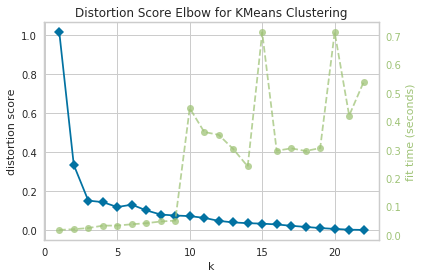

In [116]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,23))

visualizer.fit(vienna_grouped.drop('Borough', 1))    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Run k-means to cluster the boroughs into 3 clusters as determined with the elbow method

In [117]:
# set number of clusters
kclusters = 3

vienna_grouped_clustering = vienna_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vienna_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:23] 

array([1, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each borough

In [118]:
# add clustering labels
boroughs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

vienna_merged = vienna

# merge toronto_grouped with toronto_data to add latitude/longitude for each borough
vienna_merged = vienna_merged.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')

vienna_merged = vienna_merged[vienna_merged.Borough!='NaN']

vienna_merged

,Postalcode,Borough,Latitude,Longitude,EUR-Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1010,Innere Stadt,48.209075,16.369614,13290,2,Hotel,Plaza,Restaurant,Café,Austrian Restaurant,Ice Cream Shop,Italian Restaurant,Park,Museum,Art Museum
1,1020,Leopoldstadt,48.199922,16.425665,5201,0,Hotel,Austrian Restaurant,Restaurant,Café,Palace,Italian Restaurant,Pizza Place,Museum,Korean Restaurant,Irish Pub
2,1030,Landstraße,48.194205,16.395600,6142,0,Hotel,Austrian Restaurant,Café,Restaurant,Plaza,Concert Hall,Palace,Italian Restaurant,Art Museum,Steakhouse
3,1040,Wieden,48.192589,16.370290,6704,0,Hotel,Plaza,Austrian Restaurant,Palace,Ice Cream Shop,Restaurant,Concert Hall,Café,Art Museum,Asian Restaurant
4,1050,Margareten,48.187915,16.353721,5098,0,Hotel,Ice Cream Shop,Plaza,Café,Palace,Restaurant,Art Museum,Austrian Restaurant,Bar,Coffee Shop


Finally, let's visualize the resulting clusters

In [120]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

vienna_merged = vienna_merged[np.isfinite(vienna_merged['Cluster Labels'])] #exclude Boroughs with no data and therefore no Cluster Label
vienna_merged['Cluster Labels'] = vienna_merged['Cluster Labels'].astype(int) #converting Cluster Label to integer (from floating)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vienna_merged['Latitude'], vienna_merged['Longitude'], vienna_merged['Borough'], vienna_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 3.11 Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

In [123]:
vienna_merged.loc[vienna_merged['Cluster Labels'] == 0, vienna_merged.columns[[1] + [5] + [4] + list(range(6, vienna_merged.shape[1]))]]

,Borough,Cluster Labels,EUR-Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Leopoldstadt,0,5201,Hotel,Austrian Restaurant,Restaurant,Café,Palace,Italian Restaurant,Pizza Place,Museum,Korean Restaurant,Irish Pub
2,Landstraße,0,6142,Hotel,Austrian Restaurant,Café,Restaurant,Plaza,Concert Hall,Palace,Italian Restaurant,Art Museum,Steakhouse
3,Wieden,0,6704,Hotel,Plaza,Austrian Restaurant,Palace,Ice Cream Shop,Restaurant,Concert Hall,Café,Art Museum,Asian Restaurant
4,Margareten,0,5098,Hotel,Ice Cream Shop,Plaza,Café,Palace,Restaurant,Art Museum,Austrian Restaurant,Bar,Coffee Shop
5,Mariahilf,0,5548,Hotel,Plaza,Restaurant,Ice Cream Shop,Austrian Restaurant,Café,Concert Hall,Park,Art Museum,Thai Restaurant
6,Neubau,0,6667,Hotel,Café,Plaza,Ice Cream Shop,Austrian Restaurant,Restaurant,Park,Art Museum,Museum,Hostel
7,Josefstadt,0,7669,Café,Hotel,Plaza,Restaurant,Park,Austrian Restaurant,Ice Cream Shop,Coffee Shop,Art Museum,Gastropub
9,Favoriten,0,3752,Hotel,Restaurant,Austrian Restaurant,Café,Asian Restaurant,Supermarket,Park,Grocery Store,Fast Food Restaurant,Gym / Fitness Center
10,Simmering,0,4106,Hotel,Supermarket,Austrian Restaurant,Train Station,Café,Restaurant,Park,Fast Food Restaurant,Concert Hall,Grocery Store
11,Meidling,0,4468,Hotel,Zoo Exhibit,Café,Austrian Restaurant,History Museum,Restaurant,Pub,Park,Pool,Supermarket


Cluster 0: dominated by Hotels

In [124]:
vienna_merged.loc[vienna_merged['Cluster Labels'] == 1, vienna_merged.columns[[1] + [5] + [4] + list(range(6, vienna_merged.shape[1]))]]

,Borough,Cluster Labels,EUR-Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Alsergrund,1,6875,Restaurant,Plaza,Austrian Restaurant,Park,Hotel,Café,Ice Cream Shop,Cocktail Bar,Italian Restaurant,Japanese Restaurant


Cluster 1: Dominated by restaurants

In [125]:
vienna_merged.loc[vienna_merged['Cluster Labels'] == 2, vienna_merged.columns[[1] + [5] + [4] + list(range(6, vienna_merged.shape[1]))]]

,Borough,Cluster Labels,EUR-Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Innere Stadt,2,13290,Hotel,Plaza,Restaurant,Café,Austrian Restaurant,Ice Cream Shop,Italian Restaurant,Park,Museum,Art Museum
12,Hietzing,2,5587,Zoo Exhibit,Restaurant,Supermarket,Park,Bakery,Italian Restaurant,Gym / Fitness Center,Greek Restaurant,Gastropub,Ice Cream Shop
13,Penzing,2,4732,Restaurant,Supermarket,Park,Asian Restaurant,Italian Restaurant,Café,Austrian Restaurant,Scenic Lookout,Shopping Mall,Shoe Store
15,Ottakring,2,4723,Café,Austrian Restaurant,Restaurant,Park,Hotel,History Museum,Italian Restaurant,Greek Restaurant,Ice Cream Shop,Breakfast Spot
16,Hernals,2,4780,Park,Café,Supermarket,Austrian Restaurant,Restaurant,Asian Restaurant,Gastropub,Italian Restaurant,Scenic Lookout,Plaza
18,Döbling,2,7158,Austrian Restaurant,Supermarket,Wine Bar,Restaurant,Italian Restaurant,Park,Gastropub,Café,Scenic Lookout,Gym
21,Donaustadt,2,4811,Supermarket,Clothing Store,Asian Restaurant,Electronics Store,Grocery Store,Bus Stop,Bakery,Pizza Place,Gym,Restaurant


Cluster 2: Dominated by restaurants and Cafés

## 4. Discussion
- K-means does a good job clustering the boroughs of Vienna into three clusters that are dominated by different venues.
- The maximum number of venues shown by Foursquare is unfortunately somehow limited to 100.
- The coverage of venues in the boroughs by Foursquare varies.
- In my opinion it would also be useful to have categories and sub-categories as the venues “Restaurant” and “Italian Restaurant” should be in the same category.
- For the analysis it might be useful to include additional data sources like public transport connection.

## 5. Conclusion
- Foursquare offers a wide range of data for analyzing boroughs even though the data is not optimal for some reasons.
- K-means is a great method for clustering data, getting insights into data.
- The analysis made only gives an idea where you might want to buy a borough. Additional data could improve the outcome.